# Imports

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_style('white')

# Data Cleaning

In [2]:
conn = sqlite3.connect('Data/HMTG_possib_remote_pilot1.db')
dat = pd.read_sql_query('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.bonus NOTNULL', conn)
dat = dat.astype({'trl': int})


### Make sure all subjects have 45 trials. group by trustee observed

In [3]:
# Drop any subject with less than 45 trials
for trustee in dat.trustee_id.unique():
    for subject in dat.loc[dat.trustee_id == trustee].subject_id.unique():
        if dat.loc[dat.subject_id==subject].trl.max() != 44:
            dat.drop(dat.index[dat['subject_id'] == subject], inplace=True)

dat = dat.loc[dat.subID != 'prolific_subject'].reset_index(drop=True)

# Add Trustee Strategy
p2s = {54:'MO', 62:'GR', 93:'GA', 97:'IA'}
dat['p2_strategy'] = dat.trustee_id.apply(lambda x: p2s[x])

sub_count = dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))
# Add Trustee Fit params
params = pd.read_csv('Data/ParamsClusters_study-1_baseMult-4_model-MP_ppSOE_precision-100.csv', header=0, sep=',', index_col=0).reset_index(drop=True)
params.rename(columns = {'sub': 'subj'}, inplace=True)
params = params[params.subj.isin(p2s.keys())]
params.reset_index(drop=True, inplace=True)
for trustee in dat.trustee_id.unique():
    dat.loc[dat.trustee_id == trustee, 'fit_theta'] = params.loc[params.subj == trustee].theta.values[0]
    dat.loc[dat.trustee_id == trustee, 'fit_phi'] = params.loc[params.subj == trustee].phi.values[0]


### Make sure each trustee was observed by the same number of subject

In [4]:
# Ensure that each trustee was viewed by the same amount of subjects
n = sub_count.subject_id.min()

for trustee in dat.trustee_id.unique():
    subs_x_trustee = len(dat.loc[dat.trustee_id == trustee].subject_id.unique()) # number of subjects who viewed a single trustee
    if subs_x_trustee > n:
        indx2drop = np.random.choice(range(subs_x_trustee), size=(subs_x_trustee-n), replace=False) #pick random indices to drop
        subs2drop = dat.loc[dat.trustee_id == trustee].subject_id.unique()[indx2drop]  #find the subjects corresponding to random indices

        [dat.drop(dat.index[dat['subject_id'] == ss], inplace=True) for ss in subs2drop] # drop extras
dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))

,subject_id
trustee_id,
54,13
62,13
93,13
97,13


### Count the number of probe trials

In [5]:
dat['probe_trl'] = dat.reason != 'n/a'

dat['probe_num'] = np.nan

for subject in dat.subject_id.unique():
    t = 0
    for rr in dat.loc[(dat.subject_id == subject) & (dat.probe_trl == True)].iterrows():
        dat.loc[(dat.subject_id == subject) & (dat.trl == rr[1].trl), 'probe_num'] = t
        t += 1


# Compute and Plot Prediction Errors

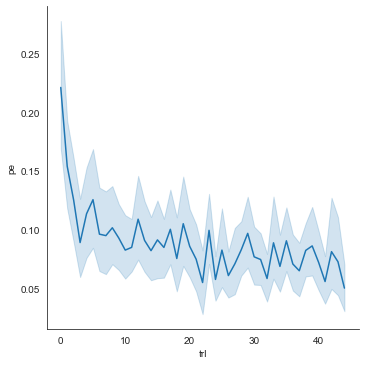

In [6]:
# Make errors between 0 and 1
dat['pe'] = abs((dat.pred/(dat.mult*dat.inv)) - (dat.ret/(dat.mult*dat.inv)))
sns.relplot(x='trl', y='pe', data=dat, kind='line')


# Make sure probes evenly spaced

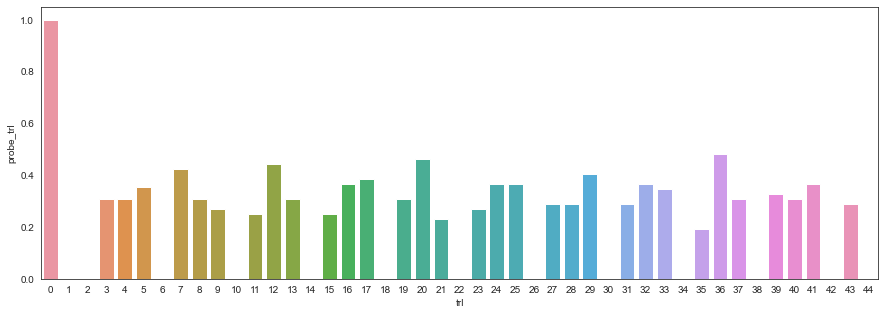

In [7]:
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=dat, x='trl', y='probe_trl', ci=None)

# Coding Responses

Initialize the empty code

In [28]:
dat['bdcode'] = 0


In [29]:

# 1: GR
# 2: GA
# 3: IA
# 4: MO
# 5: ??

n_trials = 2

for razon in dat.loc[(dat.bdcode == 0) & (dat.probe_trl == True)].reason.sample(n_trials):
    val = input(razon)
    dat.loc[dat.reason == razon, 'bdcode'] = int(val)

Save human coding

In [31]:
dat.to_csv('Data/BDcode_4_18_22.csv', sep=',')



# Let's try NLP stuff FML

In [8]:
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

#%cd /Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework


module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

def embed(input):
  return model(input)


OSError: SavedModel file does not exist at: /var/folders/y8/dlx7ymv947174gtwpprrtw380000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/{saved_model.pbtxt|saved_model.pb}

In [28]:
from glob import glob

glob(os.path.join('/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework', '*'))

['/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework/op_def.pb_text-impl.h',
 '/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework/op_def_builder.h',
 '/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework/versions.pb.h',
 '/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework/device_attributes.pb.h',
 '/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework/resource_handle.pb_text-impl.h',
 '/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/include/tensorflow/core/framework/stats_aggregator.h',
 '/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/

In [17]:
hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

OSError: SavedModel file does not exist at: /var/folders/y8/dlx7ymv947174gtwpprrtw380000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/{saved_model.pbtxt|saved_model.pb}

## Subject response similarity over time (within Trustee)

### Get average response embedding
Get mean embedding for each probe across subjects observing the same Trustee

In [14]:
dat.sort_values(['subject_id', 'trl'], inplace=True)

def get_embedding(across='trustee_id'):
    '''

    :param across: str: column in the dataframe over which to average embeddings. e.g across='trustee' will compute average embedding (at each probe #) across all subjects who observed the same trustee.
    :return: dict: mapping value of 'across' argument to a (n, 512) tensor where n = the number of probes across the "across" variable.
    e.g. if across == 'mult', n = number of times a probe followed 2,4, or 6 trials.
    '''
    temp = {}
    for bb in tqdm(dat[across].unique()):
        subs = dat.loc[(dat[across] == bb) & (dat.probe_trl == True)]
        probe_embeddings = []
        for p in range(int(subs.probe_num.max())):
            e0 = embed(subs.loc[subs.probe_num == p].reason.values.tolist())
            probe_embeddings.append(e0.numpy().mean(axis=0)) # average embedding of p_th probe across subjects viewing the same trustee
        temp[bb] = probe_embeddings
    return temp
temp = get_embedding(across='trustee_id')


  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'embed' is not defined

In [15]:
across = ['trustee_id']
for item in across:
    temp = {}
    for bb in tqdm(dat[item].unique()):
        subs = dat.loc[(dat[item] == bb) & (dat.probe_trl == True)]
        probe_embeddings = []
        for p in range(int(subs.probe_num.max())):
            e0 = embed(subs.loc[subs.probe_num == p].reason.values.tolist())
            probe_embeddings.append(e0.numpy().mean(axis=0)) # average embedding of p_th probe across subjects viewing the same trustee
        temp[bb] = probe_embeddings

sims = pd.DataFrame(columns=range(int(dat.probe_num.max())))
sims['p2_strategy'] = ''


for p2id, strat in p2s.items():
    probe_embeddings = temp[p2id]
    xx = pd.DataFrame(index=range(len(probe_embeddings)), columns=range(len(probe_embeddings)))
    for tt in range(len(probe_embeddings)):
        for ii in range(len(probe_embeddings)):
            xx.at[tt, ii] =  np.linalg.norm(probe_embeddings[tt] - probe_embeddings[ii])

    for col in xx.columns:
        xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

    xx['p2_strategy'] = strat
    sims = sims.append(xx)

  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'embed' is not defined

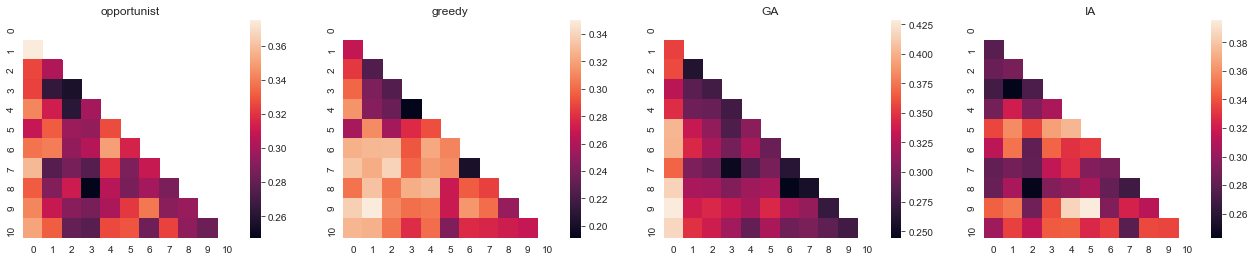

In [15]:

fig, ax = plt.subplots(figsize=(22,4), nrows=1, ncols=4)
for ii, strat  in enumerate(p2s.values()):
    yy = sims.loc[sims.p2_strategy == strat].drop('p2_strategy', axis=1)
    mask = np.zeros_like(yy.to_numpy(dtype='float64'))
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(yy, ax=ax[ii], mask=mask)
    ax[ii].set_title(strat)

## Response similarity over time across multipliers

In [16]:
mult_emb = get_embedding(across="mult")
sims = pd.DataFrame(columns=range(int(dat.probe_num.max())))


for i, m in enumerate([2, 4, 6]):
    probe_embeddings = mult_emb[m]
    xx = pd.DataFrame(index=range(len(probe_embeddings)), columns=range(len(probe_embeddings)))
    for tt in range(len(probe_embeddings)):
        for ii in range(len(probe_embeddings)):
            xx.at[tt, ii] =  np.linalg.norm(probe_embeddings[tt] - probe_embeddings[ii])

    for col in xx.columns:
        xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

    xx['mult'] = m
    sims = sims.append(xx)

100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


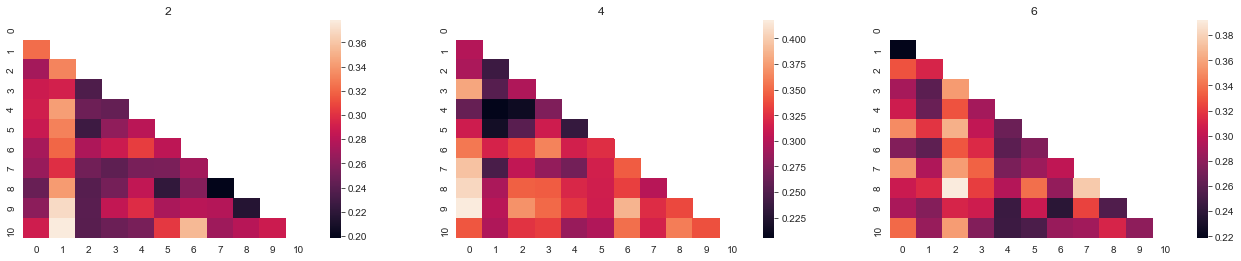

In [18]:
fig, ax = plt.subplots(figsize=(22,4), nrows=1, ncols=3)
for ii, mm  in enumerate([2, 4, 6]):
    yy = sims.loc[sims.mult == mm].drop('mult', axis=1)
    mask = np.zeros_like(yy.to_numpy(dtype='float64'))
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(yy, ax=ax[ii], mask=mask)
    ax[ii].set_title(mm)

## Response Similarity across Trustee AND multiplier

In [99]:
across = ['trustee_id', 'mult']
p2 = across[0]
m = across[1]

out_dict = {t: {m:None for m in dat[m].unique()} for t in dat[p2].unique()}
for trustee in dat[p2].unique():
    first = dat.loc[(dat[p2] == trustee) & (dat.probe_trl == True)]
    for mm in dat[m].unique():
        probe_embeddings = []
        second = first.loc[first[m] == mm]
        for p in range(int(second.probe_num.max())):
            msgs = second.loc[second.probe_num == p].reason.values.tolist()
            if len(msgs)> 0:
                e0 = embed(second.loc[second.probe_num == p].reason.values.tolist())
                probe_embeddings.append(e0.numpy().mean(axis=0))
        out_dict[trustee][mm] = probe_embeddings


def get_embeddings(dat=dat, across=[]):
    v1, v2 = across
    out_dict = {t: {m:None for m in dat[v2].unique()} for t in dat[v1].unique()}
    for i in dat[v1].unique():
        # first cross-section
        first = dat.loc[(dat[v1] == i) & (dat.probe_trl == True)]
        for j in dat[v2].unique():
            probe_embed = []
            second = first.loc[first[v2] == j]
            for probe in range(int(second.probe_num.max())):
                reasons = second.loc[second.probe_num == p].reason.values.tolist()
                if len(reasons) > 0:
                    e0 = embed(reasons)
                    probe_embed.append(e0.numpy().mean(axis=0))
            out_dict[i][j] = probe_embed
    return out_dict

oo = get_embeddings(across=['trustee_id', 'mult'])

In [34]:
sims = pd.DataFrame(columns=range(int(dat.probe_num.max())))

for trust in out_dict.keys():
    for i, m in enumerate([2, 4, 6]):
        probe_embeddings = out_dict[trust][m]
        xx = pd.DataFrame(index=range(len(probe_embeddings)), columns=range(len(probe_embeddings)))
        for tt in range(len(probe_embeddings)):
            for ii in range(len(probe_embeddings)):
                xx.at[tt, ii] =  np.linalg.norm(probe_embeddings[tt] - probe_embeddings[ii])

        for col in xx.columns:
            xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

        xx['mult'] = m
        xx['p2'] = p2s[trust]
        sims = sims.append(xx)

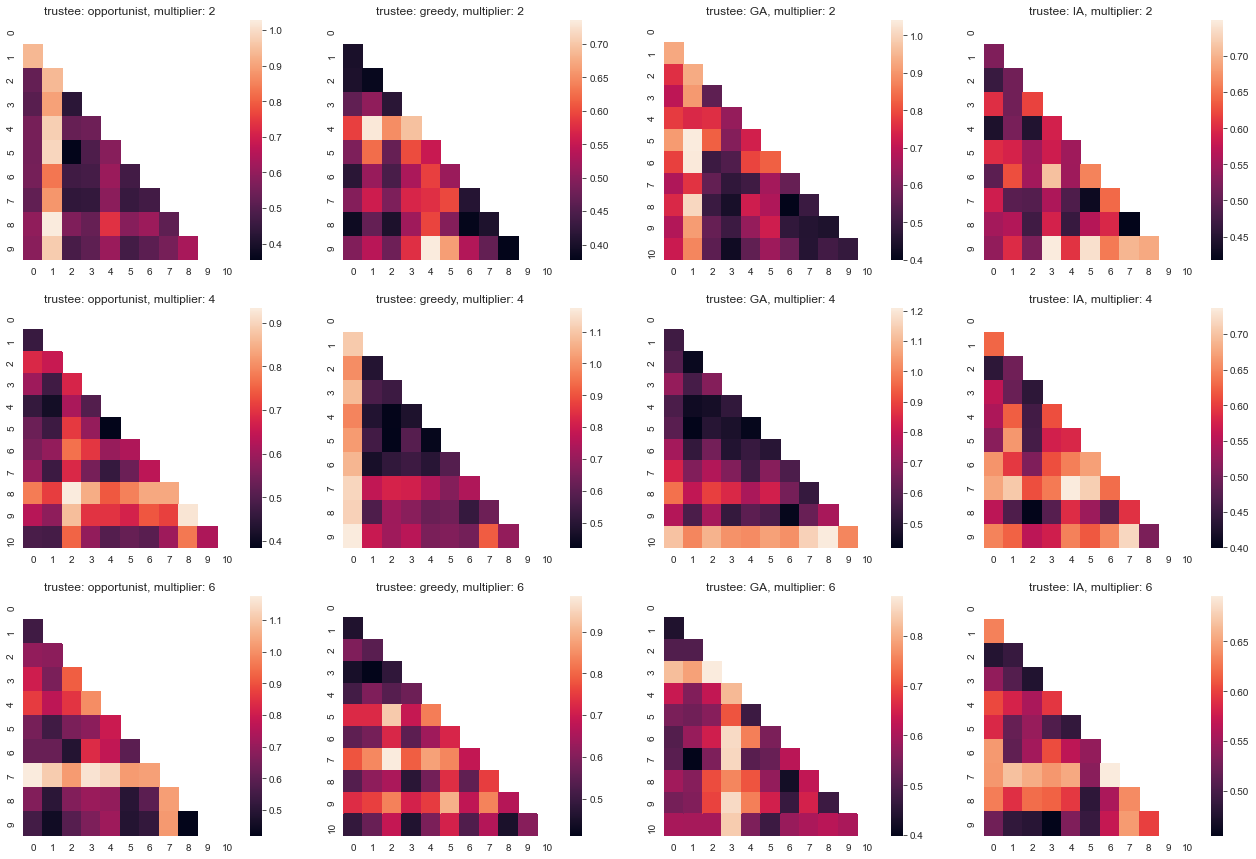

In [36]:
fig, ax = plt.subplots(figsize=(22,15), nrows=3, ncols=4)

for tti, tt in enumerate(p2s.values()):
    for ii, mm  in enumerate([2, 4, 6]):
        yy = sims.loc[(sims.p2 == tt ) & (sims.mult == mm)].drop(['mult', 'p2'], axis=1)
        mask = np.zeros_like(yy.to_numpy(dtype='float64'))
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(yy, ax=ax[ii, tti], mask=mask)
        ax[ii, tti].set_title(f'trustee: {tt}, multiplier: {mm}')

## Response Similarity across investment-multipliers

In [38]:
sorted(dat.loc[dat.probe_trl == True].inv.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [40]:
i = 'inv'
m = 'mult'

out_dict = {ii: {m:None for m in dat[m].unique()} for ii in dat[i].unique()}
for invmt in dat[i].unique():
    first = dat.loc[(dat[i] == invmt) & (dat.probe_trl == True)]
    for mm in dat[m].unique():
        probe_embeddings = []
        second = first.loc[first[m] == mm]
        for p in range(int(second.probe_num.max())):
            msgs = second.loc[second.probe_num == p].reason.values.tolist()
            if len(msgs)> 0:
                e0 = embed(second.loc[second.probe_num == p].reason.values.tolist())
                probe_embeddings.append(e0.numpy().mean(axis=0))
        out_dict[invmt][mm] = probe_embeddings

In [ ]:
dat.loc[(dat.inv ==10)&(dat.mult==4)].ret.unique()

In [102]:
CFs = {i:{m:{r:None for r in range((i*m)+1)} for m in [2,4,6]} for i in range(1,11)}
CFs[10][2]

{0: None,
 1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None,
 9: None,
 10: None,
 11: None,
 12: None,
 13: None,
 14: None,
 15: None,
 16: None,
 17: None,
 18: None,
 19: None,
 20: None}

In [104]:
i = 'inv'
m = 'mult'
for invmt in tqdm(dat[i].unique()):
    first = dat.loc[(dat[i] == invmt) & (dat.probe_trl == True)]
    for mm in dat[m].unique():
        second = first.loc[first[m] == mm]
        for r in range((invmt*mm)+1):
            probe_embeddings = []
            for p in range(int(second.probe_num.max())):
                msgs = second.loc[(second.probe_num == p)& (second.ret == r)].reason.values.tolist()
                if len(msgs)> 0:
                    e0 = embed(second.loc[second.probe_num == p].reason.values.tolist())
                    probe_embeddings.append(e0.numpy().mean(axis=0))
            CFs[invmt][mm][r] = probe_embeddings

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


# Clustering

In [106]:
CFs[10][2][1]

[]

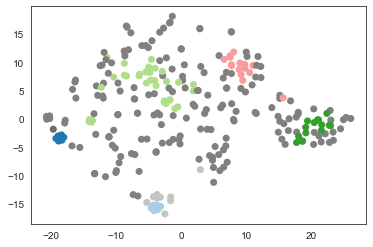

In [77]:
import hdbscan
from sklearn.manifold import TSNE

# Get a list of all reasons
reasons = dat.loc[(dat.probe_trl == True) & (dat.probe_num >= 6)].reason.tolist()
e0 = embed(reasons)
clusterer = hdbscan.HDBSCAN().fit(e0)
cc = clusterer.labels_
learned = dat.loc[(dat.probe_trl == True) & (dat.probe_num >= 6)].reset_index(drop=True)
learned['reason_clust'] = cc
projection = TSNE().fit_transform(e0)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors)

## Clusters and Parameter Space

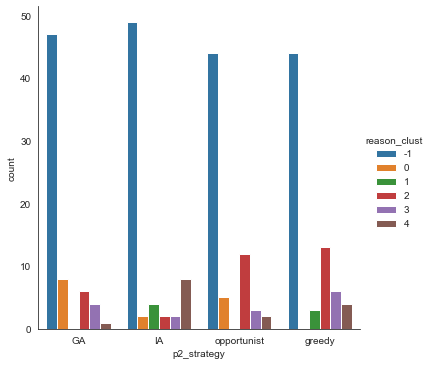

In [78]:
#learned.groupby(['p2_strategy', 'reason_clust']).count()
sns.catplot(data=learned, x='p2_strategy', hue='reason_clust', kind='count')

In [89]:
learned.loc[learned.reason_clust == -1].reason

0                                     half of the x4 roi
1       0.75 share to overcome the lower than expecte...
2                           he gave half of the return\n
3            half of the return since it was as expected
4                                   2/3rds of the amount
                             ...                        
164    so the stranger will get some of there money b...
166    so the stranger would get back some of there i...
167       he is selfish and values profit over integrity
168                      He values profit over integrity
169                 he values profit and wants max wins.
Name: reason, Length: 99, dtype: object

In [88]:
learned.loc[(learned.p2_strategy == 'opportunist') & (learned.reason_clust == 1)]

,id,trl,p1_pic,inv,mult,pred,ret,reason,reason_start,reason_rt,...,prolific_id,trustee_id,trial_order,bonus,exp_feedback,p2_strategy,probe_trl,probe_num,pe,reason_clust
93,2072,37,35,7,4,8,11,I am not sure.,5944.0,810.0,...,610838e9e68b5ba7d2717e63\n,54,1,1.62,"It was fun, but I was frustrated that I could ...",opportunist,True,9.0,0.107143,1
94,2081,40,3,5,6,10,8,I am not sure.,2730.0,994.0,...,610838e9e68b5ba7d2717e63\n,54,1,1.62,"It was fun, but I was frustrated that I could ...",opportunist,True,10.0,0.066667,1
122,2675,39,38,10,6,20,16,I don't know,7024.0,3268.0,...,614e66fd7b700bc71dace203,54,1,2.00,,opportunist,True,10.0,0.066667,1


In [81]:
#cf_outcomes = {possib: [mp_model_ppsoe(game.inv[t], game.mult[t], possib[1], possib[0]) for t in range(len(game))] for possib in possibilities}


0.2399199847020821

In [80]:

params
#xx.where(xx in [93,54])

,subj,baseMult,model,theta,phi,SSE,AIC,BIC,time,clust,ClustName
0,54,4,MP_ppSOE,0.239920,-0.042265,179.0,69.105587,73.767054,2674.602028,2,MO
1,62,4,MP_ppSOE,0.454548,0.019788,340.0,117.864133,122.525600,2123.103070,0,GR
2,93,4,MP_ppSOE,0.068870,-0.060397,70.0,-2.250095,2.411371,3472.849762,1,GA
3,97,4,MP_ppSOE,0.109027,0.048337,354.0,120.930832,125.592298,1391.829043,3,IA


In [76]:
class Reasons():
    def __init__(self):

0      False
1      False
2      False
3      False
4      False
       ...  
99     False
100    False
101    False
102    False
103    False
Name: subj, Length: 104, dtype: bool